In [1]:
%%time
from time import time
import warnings
warnings.filterwarnings('ignore')
import ml_metrics as metrics
import pandas as pd
import numpy as np
import itertools as itertools
from sklearn import cross_validation, ensemble, tree, \
    preprocessing, neighbors, naive_bayes, svm, cluster, linear_model, pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import xgboost as xgb
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]

CPU times: user 1.62 s, sys: 586 ms, total: 2.2 s
Wall time: 5.08 s


In [2]:
%%time
train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

CPU times: user 23.3 s, sys: 2.66 s, total: 26 s
Wall time: 27 s


In [3]:
%%time
# Test:  2.0 2.25 1.0 1.25 22684 5978
# Test:  1.75 2.0 9.5 9.75 21100 6806
train_reduced = train[(train.x >= .25) & (train.x <= .5) & (train.y >= .25) & (train.y < .5)]

CPU times: user 354 ms, sys: 335 ms, total: 689 ms
Wall time: 693 ms


In [4]:
%%time
train_reduced['day_number'] = ((train_reduced['time']/60)//24).astype(int)
train_reduced['seconds'] = (train_reduced['time'] * 60)
train_reduced['date_time'] = pd.to_datetime(train_reduced['seconds'],unit='s')
train_reduced['hour'] = train_reduced['date_time'].dt.hour
train_reduced['day'] = train_reduced['date_time'].dt.day
train_reduced['dow'] = train_reduced['date_time'].dt.dayofweek

CPU times: user 235 ms, sys: 19.7 ms, total: 255 ms
Wall time: 251 ms


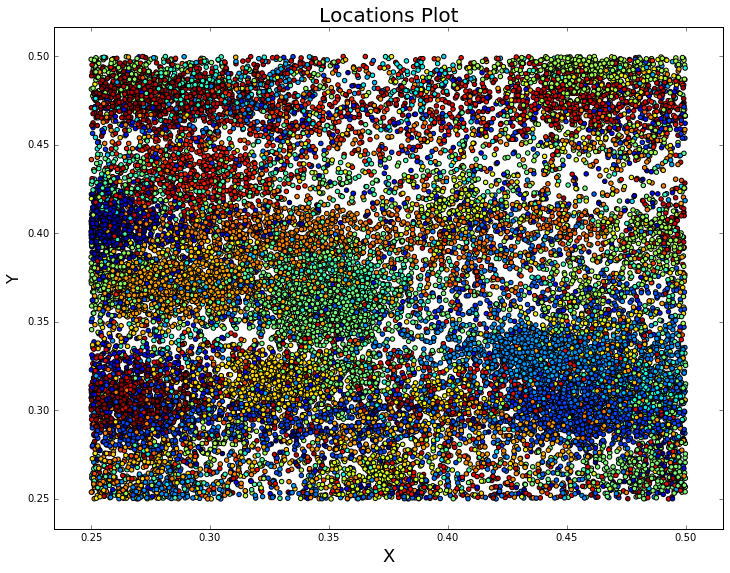

In [17]:
plt.rcParams["figure.figsize"] = [12,9]
plt.scatter(train_reduced.x,train_reduced.y, c=train_reduced.place_id)
plt.title('Locations Plot', fontsize=20)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=16)
plt.autoscale(enable=True, axis='both', tight=True)

CPU times: user 111 ms, sys: 5.36 ms, total: 116 ms
Wall time: 115 ms


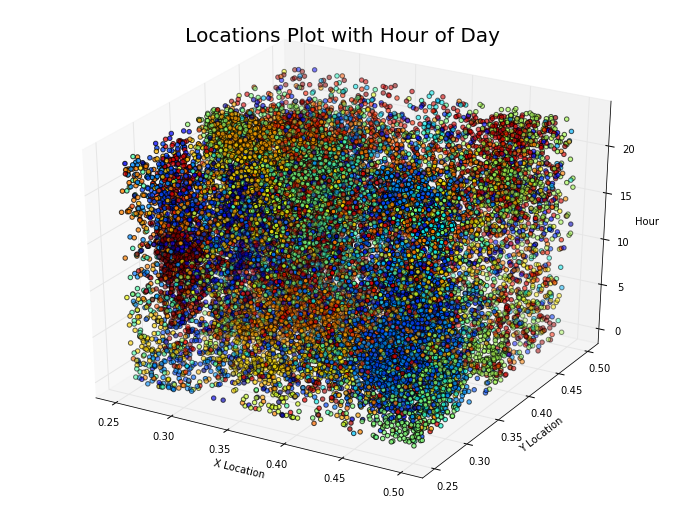

In [22]:
%%time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_reduced.x, train_reduced.y, zs=train_reduced.hour, zdir='z', s=20, c=train_reduced.place_id, depthshade=True)
plt.title('Locations Plot with Hour of Day', fontsize=20)
ax.set_xlabel('X Location')
ax.set_ylabel('Y Location')
ax.set_zlabel('Hour')
plt.autoscale(enable=True, axis='both', tight=True)

CPU times: user 141 ms, sys: 4.34 ms, total: 145 ms
Wall time: 144 ms


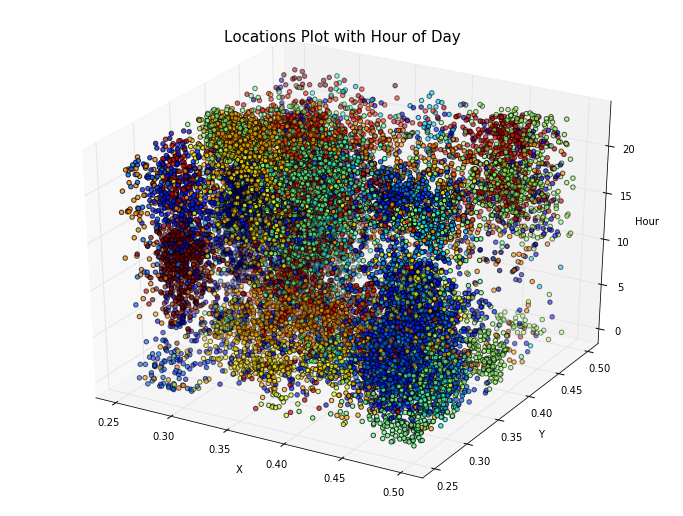

In [25]:
%%time
small_counts = train_reduced['place_id'].value_counts()
small_trainz = train_reduced[train_reduced['place_id'].isin(small_counts[small_counts > 100].index)]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(small_trainz.x, small_trainz.y, zs=small_trainz.hour, zdir='z', s=20, c=small_trainz.place_id, depthshade=True)
plt.title('Locations Plot with Hour of Day', fontsize=15)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Hour')
plt.autoscale(enable=True, axis='both', tight=True)

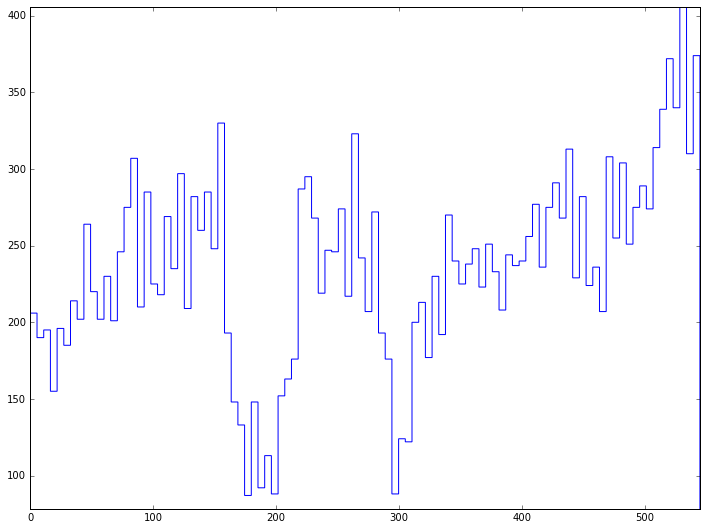

In [26]:
plt.rcParams["figure.figsize"] = [12,9]
plt.hist(train_reduced.day_number, bins=100, histtype = 'step')
plt.autoscale(enable=True, axis='both', tight=True)

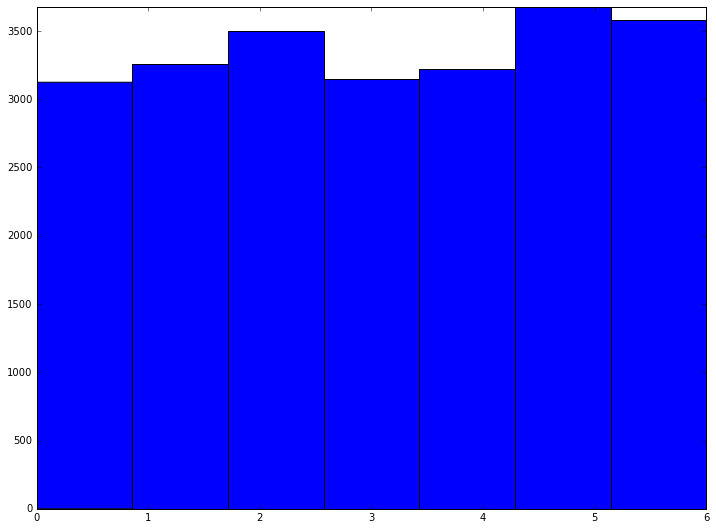

In [27]:
plt.rcParams["figure.figsize"] = [12,9]
plt.hist(train_reduced.dow, bins=7)
plt.autoscale(enable=True, axis='both', tight=True)

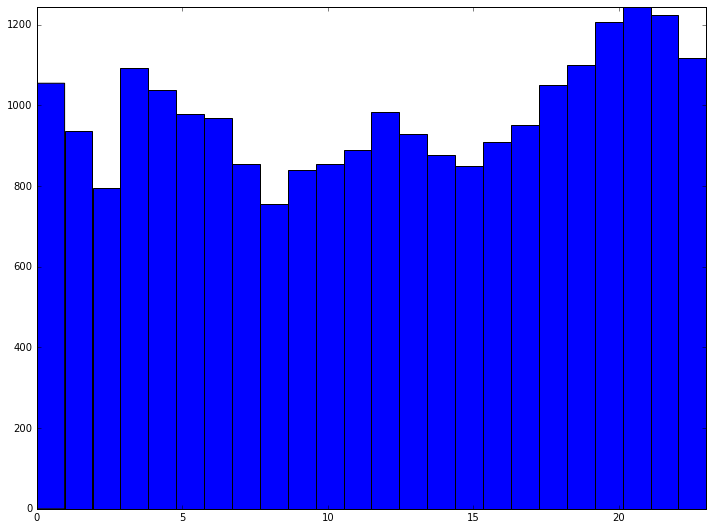

In [28]:
plt.rcParams["figure.figsize"] = [12,9]
plt.hist(train_reduced.hour, bins=24)
plt.autoscale(enable=True, axis='both', tight=True)

In [ ]:
start_time = time()

t0 = time()
print "Create ids and predictions lists..."
ids = []
predictions = []
print "Lists created:",round(time()-t0,3),"s"

t0 = time()
print "Importing training and testing sets..."
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print "Set imported:",round(time()-t0,3),"s"

def horizontally_bin_data(data, NX, NY):
    """Add columns to data indicating X and Y bins.

    Divides the grid into `NX` bins in X and `NY` bins in Y, and adds columns 
    to `data` containing the bin number in X and Y. 
    """

    NX = int(NX)
    NY = int(NY)

    assert((NX >= 5) and (NX <= 1000))
    assert((NY >= 5) and (NY <= 1000))

    x_bounds = (0., 10.)
    y_bounds = (0., 10.)

    delta_X = (x_bounds[1] - x_bounds[0]) / float(NX)
    delta_Y = (y_bounds[1] - y_bounds[0]) / float(NY)

    # very fast binning algorithm, just divide by delta and round down
    xbins = np.floor((data.x.values - x_bounds[0])
                     / delta_X).astype(np.int32)
    ybins = np.floor((data.y.values - y_bounds[0])
                     / delta_Y).astype(np.int32)

    # some points fall on the upper/right edge of the domain
    # tweak their index to bring them back in the box
    xbins[xbins == NX] = NX-1
    ybins[ybins == NY] = NY-1

    xlabel = 'x_bin_{0:03d}'.format(NX)
    ylabel = 'y_bin_{0:03d}'.format(NY)

    data[xlabel] = xbins
    data[ylabel] = ybins
    return

t0 = time()
print "Binning data..."
horizontally_bin_data(train, 100, 100)
horizontally_bin_data(test, 100, 100)
print "Data binned:",round(time()-t0,3),"s"

t0 = time()
print "Running training loop..."
estimator = 60
#Choose this line for the whole dataset.
rs = np.random.RandomState(34)
bin_numbers = zip(rs.randint(0, 100, size=5), rs.randint(0, 100, size=5))

#Choose this line for the whole dataset.
# for i_bin_x, i_bin_y in itertools.product(xrange(50,51), xrange(50,60)):
for i_bin_x, i_bin_y in bin_numbers:
    t1 = time()
    print("Bin {},{}".format(i_bin_x, i_bin_y))

    training_set = train[(train.x_bin_100 == i_bin_x) & (train.y_bin_100 == i_bin_y)]
    testing_set = test[(test.x_bin_100 == i_bin_x) & (test.y_bin_100 == i_bin_y)]

    print 'Place IDs:', len(np.unique(training_set['place_id']))
    print 'Train length:', len(training_set), 'Test length:', len(testing_set)

    minute = 2*np.pi*((training_set["time"]//5)%288)/288
    training_set['minute'] = minute
    training_set['minute_sin'] = (np.sin(minute)+1).round(4)
    training_set['minute_cos'] = (np.cos(minute)+1).round(4)
    del minute
    day = 2*np.pi*((training_set['time']//1440)%365)/365
    training_set['day'] = day
    training_set['day_of_year_sin'] = (np.sin(day)+1).round(4)
    training_set['day_of_year_cos'] = (np.cos(day)+1).round(4)
    del day
    weekday = 2*np.pi*((training_set['time']//1440)%7)/7
    training_set['weekday'] = weekday
    training_set['weekday_sin'] = (np.sin(weekday)+1).round(4)
    training_set['weekday_cos'] = (np.cos(weekday)+1).round(4)
    del weekday
    training_set['year'] = (((training_set['time'])//525600))
    training_set.drop(['time'], axis=1, inplace=True)
    training_set['month'] = ((training_set['weekday']//30)%12+1)*2.73
    training_set['accuracy'] = np.log10(training_set['accuracy'])*14.4

    training_set.loc[:,'x'] *= 465.0
    training_set.loc[:,'y'] *= 975.0
    training_set['squadd']= (training_set.x**2 + training_set.y**2)

    
    
    minute = 2*np.pi*((testing_set["time"]//5)%288)/288
    testing_set['minute'] = minute
    testing_set['minute_sin'] = (np.sin(minute)+1).round(4)
    testing_set['minute_cos'] = (np.cos(minute)+1).round(4)
    del minute
    day = 2*np.pi*((testing_set['time']//1440)%365)/365
    testing_set['day'] = day
    testing_set['day_of_year_sin'] = (np.sin(day)+1).round(4)
    testing_set['day_of_year_cos'] = (np.cos(day)+1).round(4)
    del day
    weekday = 2*np.pi*((testing_set['time']//1440)%7)/7
    testing_set['weekday'] = weekday
    testing_set['weekday_sin'] = (np.sin(weekday)+1).round(4)
    testing_set['weekday_cos'] = (np.cos(weekday)+1).round(4)
    del weekday
    testing_set['year'] = (((testing_set['time'])//525600))
    testing_set.drop(['time'], axis=1, inplace=True)
    testing_set['month'] = ((testing_set['weekday']//30)%12+1)*2.73
    testing_set['accuracy'] = np.log10(testing_set['accuracy'])*14.4

    testing_set.loc[:,'x'] *= 465.0
    testing_set.loc[:,'y'] *= 975.0
    testing_set['squadd']= (testing_set.x**2 + testing_set.y**2)

    features = [c for c in training_set.columns if c in ['year','month','dow','squadd','hour','time_kde','x_x', 'y_x','acc_norm']]

    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(training_set.place_id.values)

    forest = ensemble.RandomForestClassifier(n_estimators=estimator, min_samples_leaf=5, n_jobs=-1).fit(training_set.drop(['row_id', 'place_id', 'x_bin_100', 'y_bin_100',], axis=1).values, labels)
    probs = forest.predict_proba(testing_set.drop(['row_id', 'x_bin_100', 'y_bin_100'], axis=1).values)

    # probs.columns = np.unique(training_set['place_id'].sort_values().values)
    preds = pd.DataFrame(le.inverse_transform(np.argsort(probs, axis=1)[:,::-1][:,:3]))

    
    ids.append(list(testing_set['row_id'].values))
    predictions.append(preds.values)
    print preds.values
    print "Analysis time:",round(time()-t1,3),"s"
print "Training loop completed:",round((time()-start_time)/60,2),"m"

t0 = time()
print "Id and predictions lengths..."
print len(ids), len(predictions)
print "Printed lengths:",round(time()-t0,3),"s"

t0 = time()
print "Flattening ids and predictions lists..."
ids = [val for sublist in ids for val in sublist]
predictions = [val for sublist in predictions for val in sublist]
print "Lists flattened:",round(time()-t0,3),"s"

t0 = time()
print "Checking list lengths again..."
print len(ids), len(predictions)
print "List lengths checked:",round(time()-t0,3),"s"

t0 = time()
print "Creating submission file..."
submission = pd.DataFrame()
submission['row_id'] = ids
submission['place_id'] = [' '.join(str(x) for x in y) for y in predictions]
submission.sort_values('row_id', inplace=True)
print "Submission file created:",round(time()-t0,3),"s"

t0 = time()
print "Exporting submission file..."
submission.to_csv('final_submission.csv', index=False)
print "Submission file exported:",round(time()-t0,3),"s"

print "Script End:",round((time()-start_time)/60,2),"m"

In [ ]:
%%time
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
%%time
def horizontally_bin_data(data, NX, NY):
    """Add columns to data indicating X and Y bins.

    Divides the grid into `NX` bins in X and `NY` bins in Y, and adds columns 
    to `data` containing the bin number in X and Y. 
    """

    NX = int(NX)
    NY = int(NY)

    assert((NX >= 5) and (NX <= 1000))
    assert((NY >= 5) and (NY <= 1000))

    x_bounds = (0., 10.)
    y_bounds = (0., 10.)

    delta_X = (x_bounds[1] - x_bounds[0]) / float(NX)
    delta_Y = (y_bounds[1] - y_bounds[0]) / float(NY)

    # very fast binning algorithm, just divide by delta and round down
    xbins = np.floor((data.x.values - x_bounds[0])
                     / delta_X).astype(np.int32)
    ybins = np.floor((data.y.values - y_bounds[0])
                     / delta_Y).astype(np.int32)

    # some points fall on the upper/right edge of the domain
    # tweak their index to bring them back in the box
    xbins[xbins == NX] = NX-1
    ybins[ybins == NY] = NY-1

    xlabel = 'x_bin_{0:03d}'.format(NX)
    ylabel = 'y_bin_{0:03d}'.format(NY)

    data[xlabel] = xbins
    data[ylabel] = ybins
    return

In [ ]:
%%time
horizontally_bin_data(train, 100, 100)
# horizontally_bin_data(test, 50, 50)

In [ ]:
# %%time
estimator = 60
rs = np.random.RandomState(34)
bin_numbers = zip(rs.randint(0, 100, size=10), rs.randint(0, 100, size=10))
# bin_numbers = rs.randint(0, 100, size=20)

map3s = []
fw = [0.6, 0.32935, 0.56515, 0.2670, 22, 52, 0.51785]
#Choose this line for the whole dataset.
# for i_bin_x, i_bin_y in itertools.product(xrange(50,51), xrange(50,60)):
for i_bin_x, i_bin_y in bin_numbers:
# for i_bin_y in bin_numbers:

    t0 = time()
    print("Bin {},{}".format(i_bin_x, i_bin_y))

    # choose the correct bin, sort values in time to better simulate
    train_in_bin = train[(train.x_bin_100 == i_bin_x) & (train.y_bin_100 == i_bin_y)].sort_values('time')
    #     train_in_bin = train[(train.y_bin_1000 == i_bin_y)].sort_values('time')

    print 'Place IDs:', len(np.unique(train_in_bin['place_id']))

    training_set = train_in_bin[:int(len(train_in_bin) - (len(train_in_bin)*.25))]
    #     training_set = train_in_bin[int(len(train_in_bin)*.1):int(len(train_in_bin) - (len(train_in_bin)*.35))]

    testing_set = train_in_bin[int(len(train_in_bin) - (len(train_in_bin)*.25)):]
    

    minute = 2*np.pi*((training_set["time"]//5)%288)/288
    training_set['minute'] = minute
    training_set['minute_sin'] = (np.sin(minute)+1).round(4)
    training_set['minute_cos'] = (np.cos(minute)+1).round(4)
    del minute
    day = 2*np.pi*((training_set['time']//1440)%365)/365
    training_set['day'] = day
    training_set['day_of_year_sin'] = (np.sin(day)+1).round(4)
    training_set['day_of_year_cos'] = (np.cos(day)+1).round(4)
    del day
    weekday = 2*np.pi*((training_set['time']//1440)%7)/7
    training_set['weekday'] = weekday
    training_set['weekday_sin'] = (np.sin(weekday)+1).round(4)
    training_set['weekday_cos'] = (np.cos(weekday)+1).round(4)
    del weekday
    training_set['year'] = (((training_set['time'])//525600))
    training_set.drop(['time'], axis=1, inplace=True)
    training_set['month'] = ((training_set['weekday']//30)%12+1)*2.73
    training_set['accuracy'] = np.log10(training_set['accuracy'])*14.4

#     training_set['accuracy'] = np.log10(training_set['accuracy'])
    
#     minute = training_set.time%60
#     training_set['hour'] = training_set['time']//60
#     training_set.drop(['time'], axis=1, inplace=True)
#     training_set['weekday'] = training_set['hour']//24
#     training_set['month'] = training_set['weekday']//30
#     training_set['year'] = (training_set['weekday']//365+1)*0.22
#     training_set['hour'] = ((training_set['hour']%24+1)+minute/60.0)*0.48
#     del minute
#     pd.options.mode.chained_assignment = None
#     training_set['weekday'] = (training_set['weekday']%7+1)*1.55
#     training_set['month'] = (training_set['month']%12+1)*2.73
#     training_set['accuracy'] = np.log10(training_set['accuracy'])*14.4



#     training_set.x_x.replace(0, .0001, inplace=True)
#     training_set.y_x.replace(0, .0001, inplace=True)
    training_set.loc[:,'x'] *= 465.0
    training_set.loc[:,'y'] *= 975.0
    training_set['squadd']= (training_set.x**2 + training_set.y**2)

    
    
    minute = 2*np.pi*((testing_set["time"]//5)%288)/288
    testing_set['minute'] = minute
    testing_set['minute_sin'] = (np.sin(minute)+1).round(4)
    testing_set['minute_cos'] = (np.cos(minute)+1).round(4)
    del minute
    day = 2*np.pi*((testing_set['time']//1440)%365)/365
    testing_set['day'] = day
    testing_set['day_of_year_sin'] = (np.sin(day)+1).round(4)
    testing_set['day_of_year_cos'] = (np.cos(day)+1).round(4)
    del day
    weekday = 2*np.pi*((testing_set['time']//1440)%7)/7
    testing_set['weekday'] = weekday
    testing_set['weekday_sin'] = (np.sin(weekday)+1).round(4)
    testing_set['weekday_cos'] = (np.cos(weekday)+1).round(4)
    del weekday
    testing_set['year'] = (((testing_set['time'])//525600))
    testing_set.drop(['time'], axis=1, inplace=True)
    testing_set['month'] = ((testing_set['weekday']//30)%12+1)*2.73
    testing_set['accuracy'] = np.log10(testing_set['accuracy'])*14.4

#     testing_set['accuracy'] = np.log10(testing_set['accuracy'])
    
#     minute = testing_set['time']%60
#     testing_set['hour'] = testing_set['time']//60
#     testing_set.drop(['time'], axis=1, inplace=True)
#     testing_set['weekday'] = testing_set['hour']//24
#     testing_set['month'] = testing_set['weekday']//30
#     testing_set['year'] = (testing_set['weekday']//365+1)*0.22
#     testing_set['hour'] = ((testing_set['hour']%24+1)+minute/60.0)*0.48
#     del minute
#     testing_set['weekday'] = (testing_set['weekday']%7+1)*1.55
#     testing_set['month'] = (testing_set['month']%12+1)*2.73
#     testing_set['accuracy'] = np.log10(testing_set['accuracy'])*14.4


#     testing_set.x_x.replace(0, .0001, inplace=True)
#     testing_set.y_x.replace(0, .0001, inplace=True)
    testing_set.loc[:,'x'] *= 465.0
    testing_set.loc[:,'y'] *= 975.0
    testing_set['squadd']= (testing_set.x**2 + testing_set.y**2)

#     features = [c for c in training_set.columns if c in ['hour',
#                                                          'weekday',
#                                                          'month',
#                                                          'year',
#                                                          'hour',
#                                                          'x', 
#                                                          'y',
#                                                          'accuracy']]

    features = [c for c in training_set.columns if c in ['minute_sin', 'minute_cos', 'day_of_year_sin', 'day_of_year_cos', 'weekday_sin', 'weekday_cos', 'year', 'accuracy', 'x', 'y']]

    def calculate_distance(distances):
        return distances ** -2

    #Preparing data
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(training_set.place_id.values)

#     neigh = neighbors.KNeighborsClassifier(n_neighbors=36, weights=calculate_distance, metric='manhattan', n_jobs=-1).fit(training_set.drop(['place_id', 'x_bin_100', 'y_bin_100'], axis=1).values, labels)
    forest = ensemble.RandomForestClassifier(n_estimators=estimator, min_samples_leaf=5, n_jobs=-1).fit(training_set.drop(['place_id', 'x_bin_100', 'y_bin_100'], axis=1).values, labels)
#     bayes = naive_bayes.GaussianNB().fit(training_set[features], labels)
#     boost = xgb.XGBClassifier(objective='multi:softprob', n_estimators=10, nthread=4).fit(training_set.drop(['place_id', 'x_bin_100', 'y_bin_100'], axis=1).values, labels)
#     ensemb = EnsembleVoteClassifier(clfs=[forest, boost, bayes], weights=[2, 2, 1], voting='soft').fit(training_set[features], labels)
    probs = forest.predict_proba(testing_set.drop(['place_id', 'x_bin_100', 'y_bin_100'], axis=1).values)
#     probs.columns = le.inverse_transform(np.argsort(probs, axis=1)[:,::-1][:,:3])#np.unique(training_set['place_id'].sort_values().values)
#     preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
    map3 = mapk([[l] for l in testing_set['place_id']], le.inverse_transform(np.argsort(probs, axis=1)[:,::-1][:,:3]), 3)
    map3s.append(map3)
    print "Estimators:", estimator, "MapK:", map3
    print "Done in:",round(time()-t0,3),"s"
print np.mean(map3s)

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(training_set[features].shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], training_set[features].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(training_set[features].shape[1]), importances[indices],
       color="bisque", yerr=std[indices], align="center")
plt.xticks(range(training_set[features].shape[1]), indices)
plt.xlim([-1, training_set[features].shape[1]])
plt.show()

In [ ]:
%%time
train['seconds'] = (train['time'] * 60)
train['date_time'] = pd.to_datetime(train['seconds'],unit='s')
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['dow'] = train['date_time'].dt.dayofweek
train.x.replace(0, .0001, inplace=True)
train.y.replace(0, .0001, inplace=True)
train['div']= (train.x / train.y)
train['multi']= (train.x * train.y)
train['squadd']= (train.x**2 + train.y**2)
train['acc_squ'] = (train.accuracy**2 / (train.x / train.y))
train['acc_x'] = (train.accuracy * train.x)
train['acc_y'] = (train.accuracy * train.y)
train['vector'] = ()

# test['seconds'] = (test['time'] * 60)
# test['date_time'] = pd.to_datetime(test['seconds'],unit='s')
# test['hour'] = test['date_time'].dt.hour
# test['day'] = test['date_time'].dt.day
# test['dow'] = test['date_time'].dt.dayofweek
# test.x.replace(0, .0001, inplace=True)
# test.y.replace(0, .0001, inplace=True)
# test['div'] = (test.x / test.y)
# test['multi'] = (test.x * test.y)
# test['squadd'] = (test.x**2 + test.y**2)
# test['acc_squ'] = (test.accuracy**2 / (test.x / test.y))
# test['acc_x'] = (test.accuracy * test.x)
# test['acc_y'] = (test.accuracy * test.y)

In [ ]:
%%time
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(train_reduced[features], train_reduced['place_id'], test_size=0.70)
# features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.60)

In [ ]:
%%time
# estimators = [20,30,40,50,60,65,70]
# for estimator in estimators :
estimator = 60
t0 = time()
forest = ensemble.RandomForestClassifier(n_estimators=estimator, min_samples_leaf=5, n_jobs=-1).fit(features_train, labels_train)
probs = pd.DataFrame(forest.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print "Estimators:", estimator, "MapK:", mapk([[l] for l in labels_test], preds[0], 3)
print "Done in:",round(time()-t0,3),"s"

In [ ]:
features = [c for c in train_reduced.columns if c in ['x', 'y', 'accuracy', 'hour', 'day', 'dow', 'div', 'multi', 'squadd', 'acc_squ', 'acc_x', 'acc_y', 'vector']]

In [ ]:
%%time
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(train_reduced[features], train_reduced['place_id'], test_size=0.70)
# features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.60)

In [ ]:
%%time
# estimators = [20,30,40,50,60,65,70]
# for estimator in estimators :
estimator = 60
t0 = time()
forest = ensemble.RandomForestClassifier(n_estimators=estimator, min_samples_leaf=5, n_jobs=-1).fit(features_train, labels_train)
probs = pd.DataFrame(forest.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print "Estimators:", estimator, "MapK:", mapk([[l] for l in labels_test], preds[0], 3)
print "Done in:",round(time()-t0,3),"s"

In [ ]:
train_reduced[features].head()

In [ ]:
%%time
sample_leaf_options = [1,5,10,50,100,200,500]
for leaf_size in sample_leaf_options:
    t0 = time()
    forest = ensemble.RandomForestClassifier(n_estimators=60, min_samples_leaf=leaf_size, n_jobs=-1).fit(features_train, labels_train)
    probs = pd.DataFrame(forest.predict_proba(features_test))
    probs.columns = np.unique(labels_train.sort_values().values)
    preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
    print "Leafs:", leaf_size, "MapK:", mapk([[l] for l in labels_test], preds[0], 3)
    print "Done in:",round(time()-t0,3),"s"

In [ ]:
%%time
# Test:  2.0 2.25 1.0 1.25 22684 5978
# Test:  1.75 2.0 9.5 9.75 21100 6806
# estimators = [20,30,40,50,60,65,70]
for i in np.arange(4,5,.1):
    train_reduced = train[(train.x >= 4) & (train.x <= 4.1) & (train.y >= i) & (train.y <= (i + .1))]
    t0 = time()
    train_reduced['seconds'] = (train_reduced['time'] * 60)
    train_reduced['date_time'] = pd.to_datetime(train_reduced['seconds'],unit='s')
    train_reduced['hour'] = train_reduced['date_time'].dt.hour
    train_reduced['day'] = train_reduced['date_time'].dt.day
    train_reduced['dow'] = train_reduced['date_time'].dt.dayofweek
    train_reduced.x.replace(0, .0001, inplace=True)
    train_reduced.y.replace(0, .0001, inplace=True)
    train_reduced['div']= (train_reduced.x / train_reduced.y)
    train_reduced['multi']= (train_reduced.x * train_reduced.y)
    train_reduced['squadd']= (train_reduced.x**2 + train_reduced.y**2)
    train_reduced['acc_squ'] = (train_reduced.accuracy**2 / (train_reduced.x / train_reduced.y))
    train_reduced['acc_x'] = (train_reduced.accuracy * train_reduced.x)
    train_reduced['acc_y'] = (train_reduced.accuracy * train_reduced.y)
    features = [c for c in train_reduced.columns if c in ['x', 'y', 'accuracy', 'hour', 'day', 'dow', 'div', 'multi', 'squadd', 'acc_squ', 'acc_x', 'acc_y']]
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(train_reduced[features], train_reduced['place_id'], test_size=0.70)
    forest = ensemble.RandomForestClassifier(n_estimators=60, min_samples_leaf=5, n_jobs=-1).fit(features_train, labels_train)
    probs = pd.DataFrame(forest.predict_proba(features_test))
    probs.columns = np.unique(labels_train.sort_values().values)
    preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
    print "Estimators:", 60, "MapK:", mapk([[l] for l in labels_test], preds[0], 3)
    print "Done in:",round(time()-t0,3),"s"

In [ ]:
%%time
# neigh = neighbors.KNeighborsClassifier(weights='distance', n_jobs=-1).fit(features_train, labels_train)
forest = ensemble.RandomForestClassifier(n_estimators=60, min_samples_leaf=5, n_jobs=-1).fit(features_train, labels_train)
# bayes = naive_bayes.GaussianNB().fit(features_train.toarray(), labels_train)
# boost = xgb.XGBClassifier(learning_rate=1,
#                           n_estimators=10,
#                           max_depth=5,
#                           min_child_weight=1,
#                           gamma=0,
#                           subsample=0.8,
#                           colsample_bytree=0.8,
#                           nthread=4,
#                           scale_pos_weight=1,
#                           seed=27,
#                           objective='multi:softprob').fit(features_train, labels_train)
#  learning_rate = 1,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'multi:softprob',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27).fit(features_train, labels_train)

In [ ]:
print train_reduced['date_time'].min(), train_reduced['date_time'].max()

In [ ]:
%%time
estimator = 60
i_bin_x = 0
i_bin_y = 0
# for i_bin_y in bin_numbers:
t0 = time()
print("Bin {},{}".format(i_bin_x, i_bin_y))
#     print("Bin {}".format( i_bin_y))

# choose the correct bin, sort values in time to better simulate
train_in_bin = train[(train.x_bin_100 == i_bin_x) & (train.y_bin_100 == i_bin_y)].sort_values('time')
#     train_in_bin = train[(train.y_bin_1000 == i_bin_y)].sort_values('time')

print 'Place IDs:', len(np.unique(train_in_bin['place_id']))

training_set = train_in_bin[:int(len(train_in_bin) - (len(train_in_bin)*.25))]
#     training_set = train_in_bin[int(len(train_in_bin)*.1):int(len(train_in_bin) - (len(train_in_bin)*.35))]

testing_set = train_in_bin[int(len(train_in_bin) - (len(train_in_bin)*.25)):]

training_set['day_number'] = ((training_set['time']/60)//24).astype(int)
training_set['hour'] = (training_set['time']//60)%24+1 # 1 to 24
training_set['dow'] = (training_set['time']//1440)%7+1
training_set['month'] = (training_set['time']//43200)%12+1 # rough estimate, month = 30 days
training_set['year'] = (training_set['time']//525600)+1
# training_set['seconds'] = (training_set['time'] * 60)
# training_set['date_time'] = pd.to_datetime(training_set['seconds'],unit='s')
# training_set['hour'] = training_set['date_time'].dt.hour
# training_set['dow'] = training_set['date_time'].dt.dayofweek
# training_set['week_of_year'] = training_set['date_time'].dt.weekofyear


accuracy_means = training_set.groupby(['place_id'], as_index=False)[["x", "y", "accuracy"]].mean()
time_mean = training_set.groupby(['place_id'], as_index=False)[["hour", "dow", "month"]].mean()

accuracy_kde = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.2).fit(accuracy_means[["x", "y", "accuracy"]].values)
time_kde = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.2).fit(time_mean[["hour", "dow", "month"]].values)


training_set['acc_kde'] = accuracy_kde.score_samples(training_set[["x", "y", "accuracy"]].values)
training_set['time_kde'] = time_kde.score_samples(training_set[["hour", "dow", "month"]].values)
mean_group = training_set.groupby(['hour'], as_index=False)[["x", "y"]].mean()
training_set = pd.merge(training_set, mean_group, on='hour')
training_set['acc_norm'] = preprocessing.MinMaxScaler(feature_range=(0,25)).fit_transform(np.array(training_set.accuracy.astype(np.float)).reshape((len(training_set.accuracy), 1)))
#     training_set['time_proportion'] = ((training_set.time - training_set.time.min()) / (training_set.time.max() - training_set.time.min()))

#     training_set['r'] = np.sqrt((training_set.x_x-training_set.x_y)**2+(training_set.y_x-training_set.y_y)**2)
#     training_set['minute'] = training_set['date_time'].dt.minute

#     training_set['day'] = training_set['date_time'].dt.day
training_set.x_x.replace(0, .0001, inplace=True)
training_set.y_x.replace(0, .0001, inplace=True)
training_set['squadd']= (training_set.x_x**2 + training_set.y_x**2)
#     training_set['acc_squ'] = (training_set.accuracy**2 / (training_set.x / training_set.y))
#     training_set['acc_x'] = (training_set.accuracy * training_set.x)
#     training_set['acc_y'] = (training_set.accuracy * training_set.y)
#     training_set['time_change'] = ((training_set.time - np.mean(training_set.time))/np.std(training_set.time))

testing_set['hour'] = (testing_set['time']//60)%24+1 # 1 to 24
testing_set['dow'] = (testing_set['time']//1440)%7+1
testing_set['month'] = (testing_set['time']//43200)%12+1 # rough estimate, month = 30 days
testing_set['year'] = (testing_set['time']//525600)+1

# testing_set['seconds'] = (testing_set['time'] * 60)
# testing_set['date_time'] = pd.to_datetime(testing_set['seconds'],unit='s')
# testing_set['hour'] = testing_set['date_time'].dt.hour
# testing_set['dow'] = testing_set['date_time'].dt.dayofweek
# testing_set['week_of_year'] = testing_set['date_time'].dt.weekofyear

testing_set['acc_kde'] = accuracy_kde.score_samples(testing_set[["x", "y", "accuracy"]].values)
testing_set['time_kde'] = time_kde.score_samples(testing_set[["hour", "dow", "month"]].values)

mean_group = testing_set.groupby(['hour'], as_index=False)[["x", "y"]].mean()
testing_set = pd.merge(testing_set, mean_group, on='hour')
testing_set['acc_norm'] = preprocessing.MinMaxScaler(feature_range=(0,25)).fit_transform(np.array(testing_set.accuracy.astype(np.float)).reshape((len(testing_set.accuracy), 1)))
#     testing_set['time_proportion'] = (abs((testing_set.time - testing_set.time.min()) - testing_set.time.max()) / (testing_set.time.max() - testing_set.time.min()))

#     testing_set['r'] = np.sqrt((testing_set.x_x-testing_set.x_y)**2+(testing_set.y_x-testing_set.y_y)**2)
#     testing_set['minute'] = testing_set['date_time'].dt.minute

testing_set.x_x.replace(0, .0001, inplace=True)
testing_set.y_x.replace(0, .0001, inplace=True)
testing_set['squadd']= (testing_set.x_x**2 + testing_set.y_x**2)
#     testing_set['acc_squ'] = (testing_set.accuracy**2 / (testing_set.x / testing_set.y))
#     testing_set['acc_x'] = (testing_set.accuracy * testing_set.x)
#     testing_set['acc_y'] = (testing_set.accuracy * testing_set.y)
#     testing_set['time_change'] = ((testing_set.time - np.mean(testing_set.time))/np.std(testing_set.time))

features = [c for c in training_set.columns if c in ['year','month','dow','squadd','hour','time_kde','x_x', 'y_x','acc_norm']]


#     features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(train_in_bin[features], train_in_bin['place_id'], test_size=0.70)
forest = ensemble.RandomForestClassifier(n_estimators=estimator, min_samples_leaf=5, n_jobs=-1).fit(training_set[features], training_set['place_id'])
#     boost = xgb.XGBClassifier(objective='multi:softprob', n_estimators=estimator, nthread=4).fit(training_set[features], training_set['place_id'])
probs = pd.DataFrame(forest.predict_proba(testing_set[features]))
probs.columns = np.unique(training_set['place_id'].sort_values().values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
map3 = mapk([[l] for l in testing_set['place_id']], preds[0], 3)
# map3s.append(map3)
print "Estimators:", estimator, "MapK:", map3
print "Done in:",round(time()-t0,3),"s"

In [ ]:
%%time
# training_set = train[(train.x > 5) & (train.x < 5.25) & (train.y > 5) & (train.y < 5.25)]
training_set = train[train.x_bin_100 == 50]
training_set['day_number'] = ((training_set['time']/60)//24).astype(int)
training_set['hour'] = (training_set['time']//60)%24+1 # 1 to 24
training_set['dow'] = (training_set['time']//1440)%7+1
training_set['month'] = (training_set['time']//43200)%12+1 # rough estimate, month = 30 days
training_set['year'] = (training_set['time']//525600)+1
# training_set['seconds'] = (training_set['time'] * 60)
# training_set['date_time'] = pd.to_datetime(training_set['seconds'],unit='s')
# training_set['hour'] = training_set['date_time'].dt.hour
# training_set['dow'] = training_set['date_time'].dt.dayofweek
# training_set['week_of_year'] = training_set['date_time'].dt.weekofyear


accuracy_means = training_set.groupby(['place_id'], as_index=False)[["x", "y", "accuracy"]].mean()
time_mean = training_set.groupby(['place_id'], as_index=False)[["hour", "dow", "month"]].mean()

accuracy_kde = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.2).fit(accuracy_means[["x", "y", "accuracy"]].values)
time_kde = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.2).fit(time_mean[["hour", "dow", "month"]].values)


training_set['acc_kde'] = accuracy_kde.score_samples(training_set[["x", "y", "accuracy"]].values)
training_set['time_kde'] = time_kde.score_samples(training_set[["hour", "dow", "month"]].values)
mean_group = training_set.groupby(['hour'], as_index=False)[["x", "y"]].mean()
training_set = pd.merge(training_set, mean_group, on='hour')
training_set['acc_norm'] = preprocessing.MinMaxScaler(feature_range=(0,25)).fit_transform(np.array(training_set.accuracy.astype(np.float)).reshape((len(training_set.accuracy), 1)))
#     training_set['time_proportion'] = ((training_set.time - training_set.time.min()) / (training_set.time.max() - training_set.time.min()))

#     training_set['r'] = np.sqrt((training_set.x_x-training_set.x_y)**2+(training_set.y_x-training_set.y_y)**2)
#     training_set['minute'] = training_set['date_time'].dt.minute

#     training_set['day'] = training_set['date_time'].dt.day
training_set.x_x.replace(0, .0001, inplace=True)
training_set.y_x.replace(0, .0001, inplace=True)
training_set['squadd']= (training_set.x_x**2 + training_set.y_x**2)
#     training_set['acc_squ'] = (training_set.accuracy**2 / (training_set.x / training_set.y))
#     training_set['acc_x'] = (training_set.accuracy * training_set.x)
#     training_set['acc_y'] = (training_set.accuracy * training_set.y)
#     training_set['time_change'] = ((training_set.time - np.mean(training_set.time))/np.std(training_set.time))


In [ ]:
%%time
labels = train_reduced['place_id']
train_ids = train_reduced['row_id']
train_reduced = train_reduced[features]
# Transform the string labels to numerical using label encoder 
train_reduced.hour = le.fit_transform(train_reduced.hour)
train_reduced.day = le.fit_transform(train_reduced.day)
train_reduced.dow = le.fit_transform(train_reduced.dow)

categ = [list(train_reduced.columns).index(x) for x in 'hour', 'dow', 'day']
enc = preprocessing.OneHotEncoder(categorical_features = categ)
train_reduced['hour'] = pd.factorize(train_reduced['hour'])[0]
train_reduced['day'] = pd.factorize(train_reduced['day'])[0]
train_reduced['dow'] = pd.factorize(train_reduced['dow'])[0]
train_reduced = enc.fit_transform(train_reduced)
print train_reduced.shape

In [ ]:
%%time
labels = train_reduced['place_id']
train_ids = train_reduced['row_id']
train_reduced = train_reduced[features]

In [ ]:
%%time
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(train_reduced[features], train_reduced['place_id'], test_size=0.70)
# features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.60)

In [ ]:
%%time
probs = pd.DataFrame(boost.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
#probs.columns = np.unique(labels_train.values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print mapk([[l] for l in labels_test], preds[0], 3)

In [ ]:
%%time
probs = pd.DataFrame(forest.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
#probs.columns = np.unique(labels_train.values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print mapk([[l] for l in labels_test], preds[0], 3)

In [ ]:
%%time
probs = pd.DataFrame(bayes.predict_proba(features_test.toarray()))
probs.columns = np.unique(labels_train.sort_values().values)
#probs.columns = np.unique(labels_train.values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print mapk([[l] for l in labels_test], preds[0], 3)

In [ ]:
%%time
probs = pd.DataFrame(neigh.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
#probs.columns = np.unique(labels_train.values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print mapk([[l] for l in labels_test], preds[0], 3)

In [ ]:
submission_check = pd.read_csv('final_submission.csv')

In [ ]:
submission_check.head()

In [ ]:
submission_check.drop_duplicates('row_id', keep='first', inplace=True)

In [ ]:
dups = submission_check[submission_check.duplicated(['row_id'])].sort_values('row_id')

In [ ]:
len(dups)

In [ ]:
print len(test), len(submission_check)